In [1]:
using CMBLensing
using PythonPlot


Cℓ  = camb(r=0.05, ℓmax=21000)         
Cℓn = noiseCℓs(μKarcminT=1, ℓknee=100)


θpix  = 0.7438046267475303  # pixel size in arcmin
Nside = 512      # number of pixels per side in the map
pol   = :I       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);
bandpass_mask = LowPass(6000);

(;f, f̃, ϕ, ds) = load_sim(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = θpix,
    T = T,
    Nside = Nside,
    beamFWHM = 1.0,
    pol = pol,
    bandpass_mask = bandpass_mask, 
    #pixel_mask_kwargs = (edge_padding_deg=0, apodization_deg=0, num_ptsrcs=0),
)



┌ Error: LLVM extensions library unavailable for your platform:
│   aarch64-apple-darwin-libgfortran5-cxx11-llvm_version+18-julia_version+1.12.1
│ LLVM.jl will not be functional.
│ 
│ If you are using a custom version of LLVM, try building a
│ custom version of LLVMExtra_jll using `deps/build_local.jl`
└ @ LLVM ~/.julia/packages/LLVM/bzSzE/src/LLVM.jl:103


(f = ComplexF32[0.0f0 + 0.0f0im, -1.4355074f6 - 3.483249f6im, 3.2807038f6 - 4.531778f6im, -455595.7f0 + 120705.29f0im, -972343.9f0 + 297891.97f0im, 937233.5f0 + 1.9683731f6im, -106391.93f0 + 222771.42f0im, 379129.03f0 - 209760.14f0im, -269272.47f0 + 208467.47f0im, -43658.668f0 - 520942.03f0im  …  -2.9985697f0 + 1.7251345f0im, -10.190046f0 - 10.42925f0im, 0.3710811f0 + 3.7072842f0im, 5.331645f0 + 2.0137262f0im, -0.26298612f0 + 3.6719344f0im, 7.2763753f0 - 0.31616065f0im, -1.7443056f0 - 6.943406f0im, -11.064791f0 + 4.932134f0im, -5.0352793f0 + 7.488441f0im, 0.15712562f0 + 6.6466002f0im], f̃ = Float32[-149.3736, -147.7579, -145.56017, -143.00284, -140.87837, -139.30023, -138.73958, -138.59541, -138.75392, -138.56958  …  -87.92406, -99.09506, -109.467026, -118.06137, -124.803825, -130.9102, -136.25508, -139.98035, -142.26764, -143.0646], ϕ = ComplexF32[0.0f0 + 0.0f0im, 0.29005766f0 - 0.4476377f0im, 0.023752943f0 - 0.09520566f0im, 0.04078745f0 + 0.010236119f0im, -0.014798568f0 - 0.019218616

In [2]:
using CMBLensing: Map, Loess, PythonPlot
Base.eval(CMBLensing, :(loess = Loess.loess))

qe = quadratic_estimate(ds)
Ωstart = FieldTuple(ϕ = qe.ϕqe)


result = MAP_joint(
    ds,
    Ωstart;
    nsteps = 60,
    nburnin_update_hessian = 70,
    conjgrad_kwargs=(tol=1e-3, nsteps=100),
    progress=true
)



fJ = result.f
ϕJ = result.ϕ
hist = result.history


MAP_joint: 100%|████████████████████████████████████████| Time: 0:05:28
         step: 60
       logpdf: 6243668.00
            α: 0.0066813733
     ΔΩ°_norm: 0.00037
           CG: 4 iterations (1.13 sec)
   Linesearch: 7 bisections (3.08 sec)


60-element Vector{Any}:
 (logpdf = 6.2425525f6,)
 (logpdf = 6.24264f6,)
 (logpdf = 6.242728f6,)
 (logpdf = 6.242817f6,)
 (logpdf = 6.2428795f6,)
 (logpdf = 6.2429575f6,)
 (logpdf = 6.2430265f6,)
 (logpdf = 6.243067f6,)
 (logpdf = 6.243101f6,)
 (logpdf = 6.2431455f6,)
 (logpdf = 6.24319f6,)
 (logpdf = 6.2432265f6,)
 (logpdf = 6.2432585f6,)
 ⋮
 (logpdf = 6.243646f6,)
 (logpdf = 6.2436485f6,)
 (logpdf = 6.24365f6,)
 (logpdf = 6.243651f6,)
 (logpdf = 6.2436525f6,)
 (logpdf = 6.2436545f6,)
 (logpdf = 6.2436575f6,)
 (logpdf = 6.2436595f6,)
 (logpdf = 6.2436615f6,)
 (logpdf = 6.243663f6,)
 (logpdf = 6.2436655f6,)
 (logpdf = 6.243668f6,)

In [3]:
ϕqe = qe.ϕqe

131584-element 512×512-pixel 0.7438046267475303′-resolution LambertFourier{Array{ComplexF32, 2}}:
          -0.0f0 - 0.0f0im
    0.07469233f0 - 0.21498573f0im
   0.055961225f0 - 0.11850558f0im
    0.02958139f0 + 0.012784215f0im
   -0.01819063f0 - 0.013664416f0im
   0.009795597f0 + 0.0056719673f0im
 -0.0033131444f0 - 0.0019951828f0im
 -0.0007863296f0 + 0.0020982586f0im
  -0.001420113f0 - 0.0046372307f0im
   -7.0810594f-5 - 0.0003436504f0im
  0.0006664232f0 - 0.0012033312f0im
  0.0002453408f0 - 0.0013865351f0im
 -0.0002147708f0 - 0.0015132335f0im
                 ⋮
    6.431906f-17 - 2.4878345f-16im
    5.976204f-17 + 3.0073923f-16im
     3.14648f-17 - 1.4995045f-16im
  -1.3899759f-16 - 1.8817339f-16im
   -8.989346f-17 + 3.636491f-16im
  -3.2201453f-16 - 9.384754f-17im
   1.3323703f-17 - 2.2052827f-16im
  -1.8203019f-16 + 3.0258558f-16im
   1.8142186f-16 + 2.0497641f-17im
   2.8198092f-16 + 3.118912f-16im
  -1.6175714f-16 + 1.4784388f-16im
   1.4914039f-16 - 9.912609f-17im

<sys>:0: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


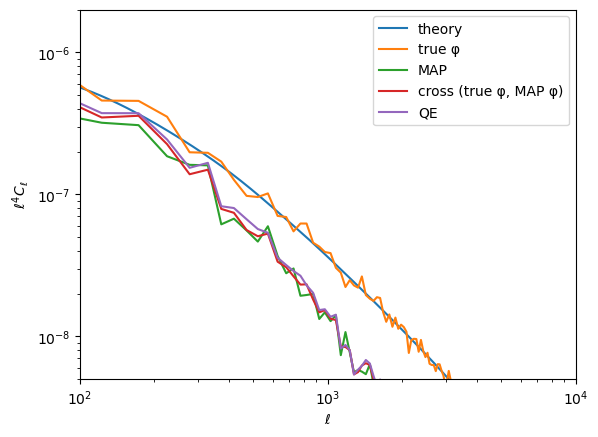

In [4]:

# ------------------------------------------------------------------
# 5) Compare spectra
# ------------------------------------------------------------------
loglog(ℓ⁴ * Cℓ.total.ϕϕ,   label="theory")
loglog(get_ℓ⁴Cℓ(ϕ),         label="true φ")
loglog(get_ℓ⁴Cℓ(ϕJ),       label="MAP")
loglog(get_ℓ⁴Cℓ(ϕ, ϕJ),    label="cross (true φ, MAP φ)") 
loglog(get_ℓ⁴Cℓ(ϕ, quadratic_estimate(ds).ϕqe), label="QE") # QE reconstruction quality
xlim(100, 10000); ylim(5e-9, 2e-6); legend()
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");
PythonPlot.show()





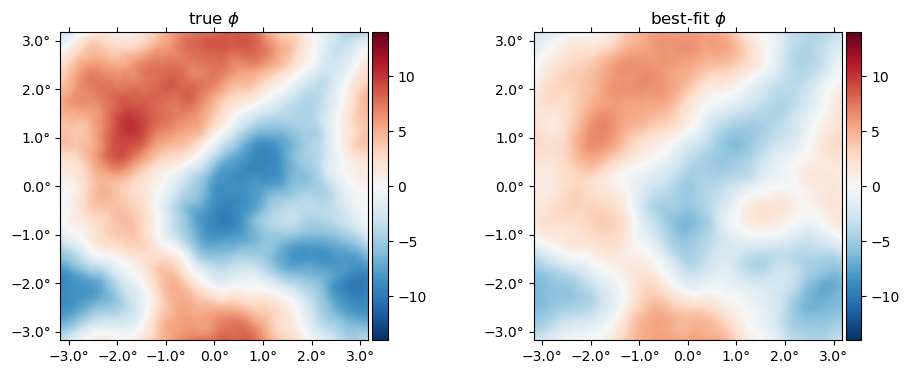

In [5]:
# ------------------------------------------------------------------
# 5) Lensing map visualisation
# ------------------------------------------------------------------
PythonPlot.plot(
    1e6 .* [ϕ  ϕJ],
    title = ["true" "best-fit"] .* raw" $\phi$",
    vlim = 14
)

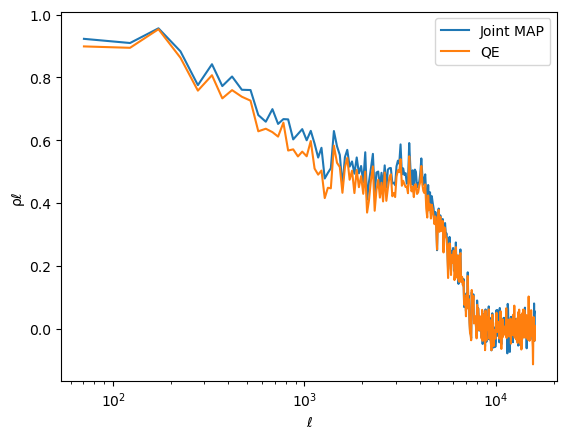

Python: <matplotlib.legend.Legend object at 0x3670842f0>

In [6]:
# ------------------------------------------------------------------
# 6) Correlation coefficient vs ell (ρℓ)
# ------------------------------------------------------------------

semilogx(get_ρℓ(ϕ, ϕJ))
semilogx(get_ρℓ(quadratic_estimate(ds).ϕqe, ϕ))
xlabel("ℓ")
ylabel("ρℓ")
legend(["Joint MAP", "QE"])

In [7]:
using FFTW
using CMBLensing: Cℓs, m_rfft, Map
using Statistics: mean


"""
    get_Cℓ_fft(ϕ1, ϕ2=ϕ1; nbins=300)

Compute the auto / cross power spectrum C_ℓ(ϕ1,ϕ2) on a flat-sky
Lambert map using FFTs. Returns a `Cℓs(ℓ, Cℓ)` object.
"""
function get_Cℓ_fft(ϕ1, ϕ2=ϕ1; nbins=300)

    # Real-space maps (Ny×Nx) and projection metadata
    m1 = Map(ϕ1)
    m2 = Map(ϕ2)

    a = m1.arr
    b = m2.arr
    Ny, Nx = size(a)
    @assert size(b) == (Ny, Nx)

    proj = m1.proj              # ProjLambert
    θpix_rad = proj.θpix * (π/180) / 60   # arcmin → radians

    # --- FFTs (rfft keeps only independent half-plane) ---
    F1 = m_rfft(a, (1,2))
    F2 = m_rfft(b, (1,2))
    NyF, NxF = size(F1)

    # Cross spectrum in Fourier space
    Pk = real.(F1 .* conj.(F2))

    # Normalise to power per steradian
    area_sr = Nx * Ny * θpix_rad^2
    Pk ./= area_sr

    # --- Build ℓ grid matching rfft layout ---
    # proj.ℓx, proj.ℓy are 1D arrays; keep the parts actually present in F1
    ℓx = proj.ℓx[1:NxF]
    ℓy = proj.ℓy[1:NyF]

    ℓx2D = repeat(ℓx', NyF, 1)
    ℓy2D = repeat(ℓy , 1,  NxF)
    ℓmap = @. sqrt(ℓx2D^2 + ℓy2D^2)

    # --- Radial binning in ℓ ---
    ℓmin, ℓmax = minimum(ℓmap), maximum(ℓmap)
    edges = range(ℓmin, ℓmax; length=nbins+1)

    Cℓ  = zeros(Float64, nbins)
    ℓc  = zeros(Float64, nbins)

    for i in 1:nbins
        mask = (edges[i] .<= ℓmap .< edges[i+1])   # BitMatrix NyF×NxF
        if any(mask)
            vals = Pk[mask]
            Cℓ[i] = mean(vals)
            ℓc[i] = mean(ℓmap[mask])
        else
            Cℓ[i] = NaN
            ℓc[i] = (edges[i] + edges[i+1]) / 2
        end
    end

    return Cℓs(ℓc, Cℓ)
end


get_Cℓ_fft

In [14]:
function bin_spectrum(ells, vals; ΔL=500)
    # Define bin edges
    Lmin = minimum(ells)
    Lmax = maximum(ells)
    edges = collect(Lmin:ΔL:Lmax)

    # Bin centres
    centers = 0.5 .* (edges[1:end-1] .+ edges[2:end])

    # Output array (same length as centres)
    binned = similar(centers)

    # Loop over bins
    for i in eachindex(centers)
        m = (ells .>= edges[i]) .& (ells .< edges[i+1])

        if any(m)
            binned[i] = mean(vals[m])
        else
            binned[i] = NaN
        end
    end

    return centers, binned
end




bin_spectrum (generic function with 1 method)

In [15]:
# QE reconstruction


# True, MAP and QE spectra
C_true     = get_Cℓ_fft(ϕ)              # C_ℓ^{φφ}
C_map      = get_Cℓ_fft(ϕJ)             # C_ℓ^{φ̂_MAP φ̂_MAP}
C_qe       = get_Cℓ_fft(ϕqe)           # C_ℓ^{φ̂_QE  φ̂_QE}
C_crossMAP = get_Cℓ_fft(ϕ, ϕJ)          # C_ℓ^{φ φ̂_MAP}
C_crossQE  = get_Cℓ_fft(ϕ, ϕqe)        # C_ℓ^{φ φ̂_QE}

ℓ = C_crossMAP.ℓ              # all have the same ℓ grid

ρ_map = C_crossMAP.Cℓ ./ sqrt.(C_true.Cℓ .* C_map.Cℓ)
ρ_qe  = C_crossQE.Cℓ  ./ sqrt.(C_true.Cℓ .* C_qe.Cℓ)


300-element Vector{Float64}:
  0.9398913948349308
  0.8913845174718665
  0.9372356389825262
  0.865961462256465
  0.8226494555425391
  0.6318602442938295
  0.6896745256100127
  0.7652337300406092
  0.607261043068514
  0.6235781545232166
  0.6020077353255898
  0.6091300663954635
  0.610174189809356
  ⋮
 -0.07075427450235722
 -0.03142879933053703
  0.0005812015662244472
 -0.10586039075648261
 -0.2194255835667379
 -0.07818048502115407
 -0.049593279632241485
  0.040619251910950095
  0.19047839823053014
 -0.005119076110716629
  0.15404405179556624
  0.4000786056844082

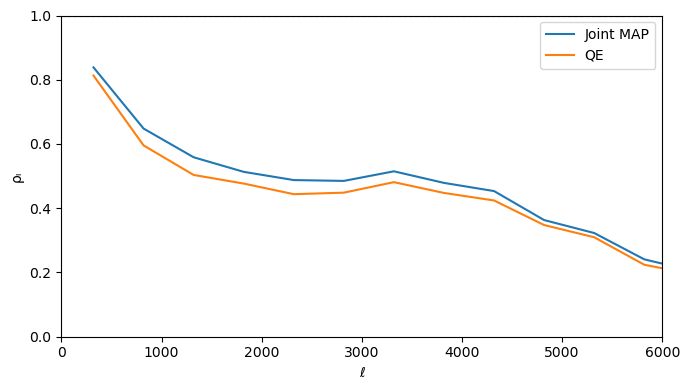

In [20]:
# --- Compute correlations ---
ρ_map = get_ρℓ(ϕ, ϕJ)
ρ_qe  = get_ρℓ(ϕqe, ϕ)

# --- Bin for smoothing ---
ΔL = 500   # Louis used ~80–100 bin widths
Lmap, ρmap_b = bin_spectrum(ρ_map.ℓ, ρ_map.Cℓ; ΔL=ΔL)
Lqe,  ρqe_b  = bin_spectrum(ρ_qe.ℓ,  ρ_qe.Cℓ;  ΔL=ΔL)

# --- Plot (linear x-axis) ---
using PythonPlot
plt.figure(figsize=(7,4))

plt.plot(Lmap, ρmap_b, label="Joint MAP")
plt.plot(Lqe,  ρqe_b,  label="QE")

plt.axhline(1, color="k", linestyle="--", linewidth=0.8)

plt.xlim(0, 6000)     # match Louis’ plot
plt.ylim(0, 1)        # match Louis’ plot

plt.xlabel("ℓ")
plt.ylabel("ρₗ")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
using CMBLensing

# Add a module-private global inside CMBLensing to hold ds
@eval CMBLensing begin
    const _DIST_DS = Ref{Any}(nothing)

    set_distributed_dataset(x) = (_DIST_DS[] = x)
    get_distributed_dataset() = _DIST_DS[]
end




# --- MAP_marg call ---
ϕ_marg, hist_marg = MAP_marg(
    ds;
    nsteps = 15,
    nsteps_with_meanfield_update = 4,
    progress = true,
    pmap = map
)


MAP_marg: 100%|█████████████████████████████████████████| Time: 0:06:07

(ComplexF32[0.0f0 + 0.0f0im, 0.1277251f0 - 0.18929625f0im, 0.067547634f0 - 0.09954399f0im, 0.0331116f0 + 0.009193543f0im, -0.017596811f0 - 0.010630946f0im, 0.0061985184f0 + 0.0009453355f0im, -0.0042209732f0 - 0.0016414713f0im, -0.0008703416f0 + 9.742423f-5im, -0.0010713992f0 - 0.0022940405f0im, 0.00043574243f0 + 0.000642546f0im  …  -1.1162749f-12 - 1.8045876f-12im, -4.561472f-12 - 6.088501f-13im, 3.2018283f-12 - 1.5161157f-12im, 5.480885f-13 + 1.2824086f-12im, 2.798371f-12 - 3.827116f-12im, -2.8254974f-12 + 1.735996f-12im, -2.3938091f-12 + 2.852367f-12im, 6.3140938f-12 + 7.3024426f-13im, -2.9854992f-12 + 6.858476f-12im, 1.7281187f-12 + 2.0621501f-12im], Any[(step = 1, g = ComplexF32[0.0f0 + 0.0f0im, 1.5330946f6 - 3.2364262f6im, 1.3555878f7 - 2.2559634f7im, 2.4389588f7 + 1.8227958f7im, -7.314857f7 - 5.326412f7im, 7.506455f7 + 7.219651f7im, -5.7999492f7 - 4.2721896f7im, 4.2804788f7 + 9.262515f7im, -1.054095f8 - 3.0242102f8im, -4.72046f7 - 6.7864344f7im  …  -62149.64f0 - 123511.17f0im, -6


        step: 15
           α: 0.2
   CG (data): 4 iterations

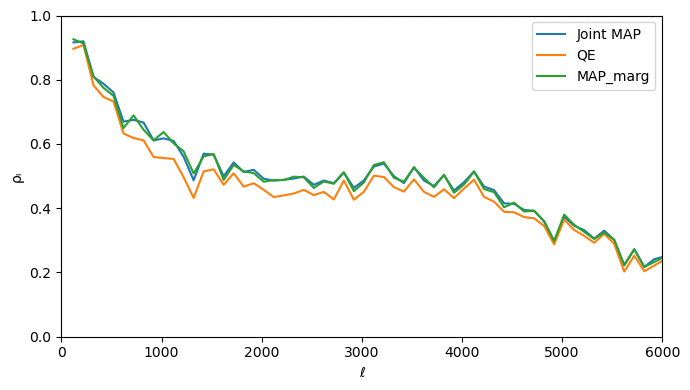

In [24]:
# --- Compute correlations ---
ρ_map  = get_ρℓ(ϕ,      ϕJ)
ρ_qe   = get_ρℓ(ϕqe, ϕ)
ρ_marg = get_ρℓ(ϕ_marg, ϕ)          # ← NEW LINE

# --- Bin for smoothing ---
ΔL = 100        # Louis used ~80–100; but your patch is smaller
Lmap,  ρmap_b  = bin_spectrum(ρ_map.ℓ,  ρ_map.Cℓ;  ΔL=ΔL)
Lqe,   ρqe_b   = bin_spectrum(ρ_qe.ℓ,   ρ_qe.Cℓ;   ΔL=ΔL)
Lmarg, ρmarg_b = bin_spectrum(ρ_marg.ℓ, ρ_marg.Cℓ; ΔL=ΔL)   # ← NEW LINE

# --- Plot (linear x-axis) ---
using PythonPlot
plt = PythonPlot
plt.figure(figsize=(7,4))

plt.plot(Lmap,  ρmap_b,  label="Joint MAP")
plt.plot(Lqe,   ρqe_b,   label="QE")
plt.plot(Lmarg, ρmarg_b, label="MAP_marg")     # ← NEW LINE

plt.axhline(1, color="k", linestyle="--", linewidth=0.8)

plt.xlim(0, 6000)      # match Louis’ plots
plt.ylim(0, 1)

plt.xlabel("ℓ")
plt.ylabel("ρₗ")
plt.legend()
plt.tight_layout()
plt.show()
